# Predicting Price Of Renting An Apartment In Lagos State.

The objective of this project is predicting the cost of renting an apartment in lagos state based on the area, number of bed rooms and number of toilets.
Data set for this project was gathered from https://tolet.ng, also scrapper for gathered the data can be found on my github here -> https://github.com/victorlenerd/toletngscrapper.

## Loading And Cleaning Data.

In [1]:
## Loading Data
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
import sklearn.metrics as sm
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
import math


sns.set_style("whitegrid")

%matplotlib inline

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_json('./data.all.json')
df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17214 entries, 0 to 17213
Data columns (total 8 columns):
address              17214 non-null object
lat                  17213 non-null float64
lng                  17213 non-null float64
no_bath              17212 non-null object
no_bed               17214 non-null object
no_parking_spaces    7185 non-null float64
no_toilets           17213 non-null object
price                17070 non-null float64
dtypes: float64(4), object(4)
memory usage: 1.2+ MB


In [3]:
df.describe()

,lat,lng,no_parking_spaces,price
count,17213.000000,17213.000000,7185.000000,1.707000e+04
mean,6.511095,305.599635,10.058733,2.740115e+06
std,0.070590,10991.660177,213.872935,5.470854e+07
min,6.409760,2.887644,0.000000,1.000000e-02
25%,6.451514,3.360304,0.000000,5.000000e+05
50%,6.500500,3.421944,1.000000,1.000000e+06
75%,6.564985,3.469745,3.000000,2.000000e+06
max,7.539378,400106.000000,12345.000000,5.000000e+09


In [4]:
df = df.drop('address', axis=1)

In [5]:
def clean_nums(num):
    try:
        return int(num)
    except ValueError:
        return 0
    except TypeError:
        return num

df['no_bed'] = df['no_bed'].apply(clean_nums)
df['no_bath'] = df['no_bath'].apply(clean_nums)
df['no_toilets'] = df['no_toilets'].apply(clean_nums)
df['no_parking_spaces'] = df['no_parking_spaces'].apply(clean_nums)

In [6]:
df = df[df['no_bed'] > 1]
df = df[df['no_bed'] < 10]

df = df[df['no_bath'] > 1]
df = df[df['no_bath'] < 10]

df = df[df['no_toilets'] > 1]
df = df[df['no_toilets'] < 10]

In [7]:
def clean_park(r):
    if r['no_bed'] > 2 and r['no_parking_spaces'] < 1:
        r['no_parking_spaces'] = 1 
        return r
    
    return r
    
df = df.apply(clean_park, axis=1)
df = df[df['no_parking_spaces'] < 10]

In [8]:
df = df[np.isfinite(df['price'])]

In [9]:
df = df.dropna()

In [10]:
df.describe()

,lat,lng,no_bath,no_bed,no_parking_spaces,no_toilets,price
count,11734.000000,11734.000000,11734.000000,11734.000000,11734.000000,11734.000000,1.173400e+04
mean,6.511135,173.912558,2.759076,2.733680,1.212374,3.363985,3.174673e+06
std,0.071302,8257.703129,0.651095,0.554439,1.359480,0.787831,6.534907e+07
min,6.409760,2.887644,2.000000,2.000000,0.000000,2.000000,1.000000e+00
25%,6.451514,3.360304,2.000000,2.000000,0.000000,3.000000,7.000000e+05
50%,6.500235,3.421944,3.000000,3.000000,1.000000,3.000000,1.200000e+06
75%,6.574725,3.469745,3.000000,3.000000,1.000000,4.000000,2.500000e+06
max,6.718915,400106.000000,8.000000,8.000000,9.000000,9.000000,5.000000e+09


### Visualizing Data

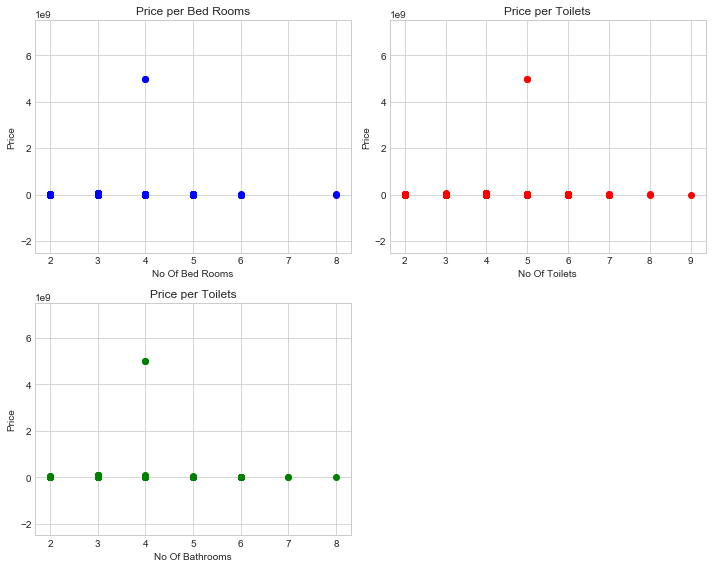

In [11]:
plt.figure(figsize=(10,8))

low = np.min(df['price'])
high = np.max(df['price'])

plt.subplot(2, 2, 1)
plt.scatter(x=df['no_bed'], y=df['price'], color='blue')
plt.title('Price per Bed Rooms')
plt.xlabel('No Of Bed Rooms')
plt.ylabel('Price')
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

plt.subplot(2, 2, 2)
plt.scatter(df['no_toilets'], df['price'], color='red')
plt.title('Price per Toilets')
plt.xlabel('No Of Toilets')
plt.ylabel('Price')
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

plt.subplot(2, 2, 3)
plt.scatter(df['no_bath'], df['price'], color='green')
plt.title('Price per Toilets')
plt.xlabel('No Of Bathrooms')
plt.ylabel('Price')
plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

plt.tight_layout()
plt.show()

(-2499999998, 7500000000)

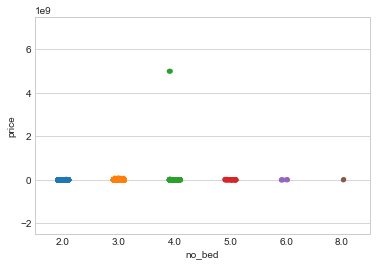

In [12]:
low = np.min(df['price'])
high = np.max(df['price'])
sp = sns.stripplot(x=df["no_bed"], y=df["price"], jitter=True)
sp.set_ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

# Model Development

The accuracy of the model used would be measured using: 
   * **Mean Squared Error**: This is the average of the squares of the errors of all the datapoints in the given dataset.
   * **Explained Variance Score**: This score measures how well our model can account for the variation in our dataset.
   * **R2-score**: This tells us how well the unknown samples will be predicted by our model.

In [13]:
def accuracy(test, pred):
    print("Mean Squared Error: ", round(sm.mean_squared_error(test, pred), 2))
    print("Explained Variance Score: ", round(sm.explained_variance_score(test, pred),2))
    print("R2-score: ", round(sm.r2_score(test, pred), 2))

## Spliting data for train and test

In [14]:
price = pd.Series(df['price'], dtype='float32')
feature_final = df.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(feature_final,
                                                    price,
                                                    test_size = 0.2,
                                                    random_state = 1)

In [15]:
print("Training set has {} samples.", X_train.shape)
print("Testing set has {} samples.", y_train.shape)

Training set has {} samples. (9387, 6)
Testing set has {} samples. (9387,)


### Base Model Performance

In [23]:
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [24]:
y_train_pred = linear_regressor.predict(X_train)

In [27]:
accuracy(y_train, y_train_pred)

Mean Squared Error:  2.6672989221e+15
Explained Variance Score:  0.0
R2-score:  0.0
